# Donut Fine-tuning

El presente notebook es el proceso de fine-tuning para [DoNut-base](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://huggingface.co/naver-clova-ix/donut-base-finetuned-cord-v2&ved=2ahUKEwjMh4O54vGNAxVsIrkGHQznKskQFnoECBcQAQ&usg=AOvVaw1uKtlO2jgCL6oC_haM4FIB).

In [2]:
import torch
from sqlalchemy.testing.plugin.plugin_base import include_tags

from models.donut import DonutModel

from torch.utils.data import DataLoader
from datasets import load_dataset
#from transformers import MobileViTForImageClassification, MobileViTImageProcessor
from transformers import ViTForImageClassification, ViTImageProcessor, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import TrainingArguments, Trainer
import matplotlib.pyplot as plt
import numpy as np

from scripts.attention_viz import create_attention_overlay

2025-06-20 16:56:38.658375: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-20 16:56:38.667530: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750449398.677945   21806 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750449398.681021   21806 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750449398.690352   21806 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [6]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(device) # Expected: ‘cuda’ if Linux else ‘mps’ if MacOS
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

cuda


In [7]:
import transformers

print(torch.__version__)
print(transformers.__version__)

2.6.0+cu126
4.52.4


# Cargando variables de entorno

In [8]:
from dotenv import load_dotenv
import os

# Try different .env paths
env_path = os.path.join("..",".env")
# env path using os path join
    
print(f"🔍 Trying .env path: {env_path}")

# Load environment variables
found = load_dotenv(env_path)
print(f"✅ .env file {'found' if found else 'not found'}")

# Verify loaded variables
print("\n🔎 Environment variables:")
for var in ["PROCESSED_DATA_DIR", "RAW_DATA_DIR", "CHECKPOINT_DIR"]:
    value = os.getenv(var)
    print(f"{var}: {'✅' if value else '❌'} {value}")

img_dir_train = os.path.join(os.getenv("RAW_DATA_DIR"),'train2014')
img_dir_val = os.path.join(os.getenv("RAW_DATA_DIR"),'val2014')
img_dir_test =  os.path.join(os.getenv("RAW_DATA_DIR"),'test2014')
ann_coco_text = os.path.join("..","data","raw",'cocotext.v2.json')

print(ann_coco_text)

🔍 Trying .env path: ../.env
✅ .env file found

🔎 Environment variables:
PROCESSED_DATA_DIR: ✅ /home/juan/CEIA/vpc3-proyecto/vpc3_proyecto/data/processed
RAW_DATA_DIR: ✅ /home/juan/CEIA/CEIA-ViT/TrabajosPracticos/TP_Final/data/raw
CHECKPOINT_DIR: ✅ /home/juan/CEIA/vpc3-proyecto/vpc3_proyecto/models
../data/raw/cocotext.v2.json


# Evaluamos modelo finetuneado  para ver si mejoro alguna metrica

In [9]:
from vpc3_proyecto.model_training.dataset_donut_model import OCRDataset
from vpc3_proyecto.model_evaluation.utils import get_last_checkpoint_folder
import torch
import glob
from transformers import VisionEncoderDecoderModel, DonutProcessor

torch.cuda.empty_cache()
donut_checkpoint_dir =os.path.join(os.getenv("CHECKPOINT_DIR"),'finetuned_donut_weights')#TODO: promptear al usuario detectando las carpetas dentro de checkpint directory para que elija que folder usar / que modelo guardado elegir
last_ckpt = get_last_checkpoint_folder(donut_checkpoint_dir)
manually_saved_folder = os.path.join(donut_checkpoint_dir,"checkpoint-10873", "manually-saved")

In [10]:


processor = DonutProcessor.from_pretrained(manually_saved_folder,do_resize=True,use_fast=True)

model = VisionEncoderDecoderModel.from_pretrained(manually_saved_folder).to(device)
# processor = DonutProcessor.from_pretrained(manually_saved_folder)
# 
# model = VisionEncoderDecoderModel.from_pretrained(
#     manually_saved_folder,
#     device_map="auto",
#     torch_dtype=torch.float16  
# )


test_dataset = OCRDataset(
    img_dir_test,  
    processor=processor,
    max_length=512,
    annotation_file=ann_coco_text
)
model.config.decoder_start_token_id = processor.tokenizer.pad_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id


🔍 Loading annotations from ../data/raw/cocotext.v2.json ...
✅ Found 17141 images with legible annotations.
📄 Filtered dataset from 1572 to 1572 images.


In [9]:
print(f"Model device: {model.device}")
print(f"Vocab size: {model.config}")

Model device: cuda:0
Vocab size: VisionEncoderDecoderConfig {
  "architectures": [
    "VisionEncoderDecoderModel"
  ],
  "decoder": {
    "activation_dropout": 0.0,
    "activation_function": "gelu",
    "add_cross_attention": true,
    "add_final_layer_norm": true,
    "attention_dropout": 0.0,
    "classifier_dropout": 0.0,
    "d_model": 1024,
    "decoder_attention_heads": 16,
    "decoder_ffn_dim": 4096,
    "decoder_layerdrop": 0.0,
    "decoder_layers": 4,
    "dropout": 0.1,
    "encoder_attention_heads": 16,
    "encoder_ffn_dim": 4096,
    "encoder_layerdrop": 0.0,
    "encoder_layers": 12,
    "init_std": 0.02,
    "is_decoder": true,
    "is_encoder_decoder": false,
    "max_position_embeddings": 1536,
    "model_type": "mbart",
    "num_hidden_layers": 12,
    "scale_embedding": true,
    "torch_dtype": "float32",
    "use_cache": true,
    "vocab_size": 57525
  },
  "decoder_start_token_id": 1,
  "encoder": {
    "attention_probs_dropout_prob": 0.0,
    "depths": [
     

In [ ]:
from vpc3_proyecto.model_evaluation.utils import manual_evaluate

metrics ,results_df = manual_evaluate(
    model=model,
    dataset=test_dataset,
    processor=processor,
    max_samples=None  ,
    results_save_path=manually_saved_folder+'/test'
)

  6%|▋         | 100/1572 [01:24<21:04,  1.16it/s]

In [1]:
results_df

NameError: name 'results_df' is not defined

In [15]:
metrics

{'mean_char_accuracy': -0.024564494030142884,
 'mean_cer': 1.0567295739631597,
 'exact_match_rate': 0.0,
 'total_samples': 1572}

In [14]:
sample_0 = test_dataset[0]
sample_1 = test_dataset[1351]
sample_11 = test_dataset[12]

In [11]:
sample_0.keys()

dict_keys(['pixel_values', 'labels', 'img_path'])

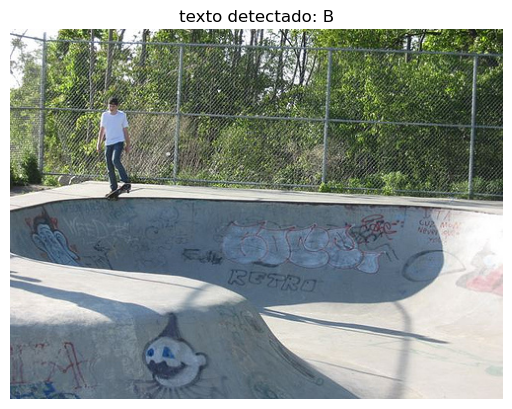

Ground truth: RETRO


In [17]:
from PIL import Image

try:
    image = Image.open(sample_1['img_path']).convert("RGB")
except FileNotFoundError:
    print(f"Error: Image not found at {sample_1['img_path']}")
    exit()

from vpc3_proyecto.visualization.infer_from_image import infer_text_from_image
task_prompt = None
gt_text = processor.tokenizer.decode( sample_1['labels'][ sample_1['labels'] != -100]) 
result_text = infer_text_from_image(image, model, processor,task_prompt=None,show_image=True)
print("Ground truth:",df.iloc[1351]["text"])

In [20]:
donut_model = DonutModel()

In [29]:

# donut_model.load_model(model_path=manually_saved_folder)
donut_model.evaluate("../data/processed/val2014",model_path=manually_saved_folder)

The channel dimension is ambiguous. Got image shape torch.Size([3, 7, 3]). Assuming channels are the first dimension. Use the [input_data_format](https://huggingface.co/docs/transformers/main/internal/image_processing_utils#transformers.image_transforms.rescale.input_data_format) parameter to assign the channel dimension.
The channel dimension is ambiguous. Got image shape torch.Size([3, 5, 3]). Assuming channels are the first dimension. Use the [input_data_format](https://huggingface.co/docs/transformers/main/internal/image_processing_utils#transformers.image_transforms.rescale.input_data_format) parameter to assign the channel dimension.


({'mean_char_accuracy': 0.038341977677182934,
  'mean_cer': 0.9393732453145155,
  'exact_match_rate': 0.0011135857461024498,
  'total_samples': 2694},
      prediction ground_truth  char_accuracy  edit_distance
 0             W           CO       0.000000              2
 1             S      CEREZIN       0.000000              7
 2            TO     robotin        0.142857              6
 3             W         CITY       0.000000              4
 4             W           11       0.000000              2
 ...         ...          ...            ...            ...
 2689          W         7514       0.000000              4
 2690          W           HE       0.000000              2
 2691          W           4C       0.000000              2
 2692          W      Pascual       0.000000              7
 2693          W   11-09-2012       0.000000             10
 
 [2694 rows x 4 columns])